# **-Dependencias y archivos para que funcione el modelo**

In [1]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

# Instalamos las dependencias con la versión optimizada de xformers
!pip install httpx --upgrade
!pip install langsmith --upgrade
!pip install openai --upgrade
!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2


# Descargamos el modelo usando aria2 para descargarlo rapidamente
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors
#!pip install googletrans==4.0.0-rc1 --use-deprecated=legacy-resolver
!pip install deepl

#Importamos las librerias que vamos a usar
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
#from googletrans import Translator

# Inicializa el traductor
#translator = Translator()


# Cargamos las clases de node que vamos a usar
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

# Habilitamos las optimizaciones de rendimiento de PyTorch
torch.set_float32_matmul_precision('high')
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)

# Cargamos los modelos con inference_mode y compilación potencial para mayor velocidad.
with torch.inference_mode(), torch.autocast("cuda"):   #con GPU
#with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    # Compilamos el modelo CLIP para una posible aceleración (si es compatible)
    try:
        clip = torch.compile(clip, mode="reduce-overhead", fullgraph=True)
    except Exception as e:
        print(f"Peligro: No se pudo compilar el modelo CLIP: {e}")

    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    # Compilamos el modelo UNET
    try:
        unet = torch.compile(unet, mode="reduce-overhead")
    except Exception as e:
        print(f"Peligro: No se pudo compilar el modelo CLIP: {e}")

    vae = VAELoader.load_vae("ae.sft")[0]


def closestNumber(n, m):

   return (n // m) * m

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 23.91 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (9819/9819), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.6
    Uninstalling langsmith-0.3.6:
      Successfully uninstalled langsmith-0.3.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Peligro: No se pudo compilar el modelo CLIP: 
Peligro: No se pudo compilar el modelo CLIP: 


# **-Funcion para convertir de texto a imagen**

In [2]:
def textoimagen():
  with torch.inference_mode():
      positive_prompt = translation.text
      width = 512                         #tamaño de la imagen
      height = 512
      seed = 0                            #Seed para generar la imagen
      steps = 10                          #Pasos para asegurar que la imagen sea de buena calidad
      sampler_name = "euler"              #Usamos el muestreador Euler
      scheduler = "simple"                #Usamos un programador basico para reducir el ruido en la imagen

      if seed == 0:
          seed = random.randint(0, 18446744073709551615)
      #print(seed)  #esto es para ver que seeds salian al generar una imagen

      cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True) #Esta linea utiliza el modelo CLIP para procesar el positive_prompt
      cond = [[cond, {"pooled_output": pooled}]]                                                 #clip.tokenize divide el texto en tokens luego se obtienen dos salidas: cond y pooled
      noise = RandomNoise.get_noise(seed)[0]                                                     #aqui se genera un tensor de ruido aleatorio con la seed para empezar a generar la imagen
      guider = BasicGuider.get_guider(unet, cond)[0]                                             #aqui se genera una guía que ayudara a dirigir el proceso de generación de la imagen para que se ajuste a la descripcion
      sampler = KSamplerSelect.get_sampler(sampler_name)[0]                                      #aqui el muestreador define la estrategia para refinar la imagen durante la generación
      sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]                         #aqui los sigmas controlan la cantidad de ruido que se agrega o elimina en cada paso de la generacion
      latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]      #aqui se crea una imagen latente vacía  con las dimensiones especificadas por width y height
      sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)  #esta es la linea principal donde se realiza la generacion de la imagen
      model_management.soft_empty_cache()                                                             #aqui se libera memoria de cache de los modelos para evitar problemas de memoria
      decoded = VAEDecode.decode(vae, sample)[0].detach()                                             #aqui la imagen latente se decodifica utilizando el VAE para obtener una imagen real (decoded)
      Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/ImagenGenerada.png")   #la imagen decodificada (decoded) se convierte a una imagen PIL y se guarda en la ruta establecida

  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])                                           #Se devuelve la imagen PIL generada.
  return Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

# **-Funcion para separar los textos largos**

In [9]:
def split_text_large_input(text,                 # Texto largo a separar
                          min_chunk_length=150,  # Mínimo de caracteres por chunk
                          split_method="smart",  # Opciones: "sentence", "paragraph", "fixed"
                          overlap_sentences=1):  # Solapamiento entre chunks

    # Preprocesamiento: eliminar espacios extras y saltos de línea múltiples
    text = re.sub(r'\s+', ' ', text.strip())

    # Método 1: Dividir por oraciones naturales
    if split_method == "sentence":
        sentences = sent_tokenize(text)
        chunks = []
        current_chunk = []
        current_length = 0

        for sentence in sentences:
            if current_length + len(sentence) <= min_chunk_length or not current_chunk:
                current_chunk.append(sentence)
                current_length += len(sentence)
            else:
                if current_length < min_chunk_length:
                    additional_sentence = sentences.pop(0)
                    current_chunk.append(additional_sentence)
                    current_length += len(additional_sentence)
                chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_length = len(sentence)

        if current_chunk:
            if current_length < min_chunk_length and len(sentences) > 0:
                additional_sentence = sentences.pop(0)
                current_chunk.append(additional_sentence)
                current_length += len(additional_sentence)
            chunks.append(" ".join(current_chunk))

    # Método 2: Dividir por párrafos (doble salto de línea)
    elif split_method == "paragraph":
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
        chunks = []

        for para in paragraphs:
            if len(para) > min_chunk_length:
                sub_chunks = split_text_large_input(para, min_chunk_length, "sentence")
                chunks.extend(sub_chunks)
            else:
                chunks.append(para)

    # Método 3: División fija por longitud
    elif split_method == "fixed":
        chunks = [text[i:i+min_chunk_length] for i in range(0, len(text), min_chunk_length)]

    # Método "smart": Combina párrafos y oraciones
    else:
        paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
        chunks = []

        for para in paragraphs:
            if len(para) <= min_chunk_length:
                chunks.append(para)
            else:
                sentences = sent_tokenize(para)
                current_chunk = []
                current_length = 0

                for sentence in sentences:
                    if current_length + len(sentence) <= min_chunk_length or not current_chunk:
                        current_chunk.append(sentence)
                        current_length += len(sentence)
                    else:
                        if current_length < min_chunk_length:
                            additional_sentence = sentences.pop(0)
                            current_chunk.append(additional_sentence)
                            current_length += len(additional_sentence)
                        chunks.append(" ".join(current_chunk))
                        current_chunk = [sentence]
                        current_length = len(sentence)
                if current_chunk:
                    if current_length < min_chunk_length and len(sentences) > 0:
                        additional_sentence = sentences.pop(0)
                        current_chunk.append(additional_sentence)
                        current_length += len(additional_sentence)
                    chunks.append(" ".join(current_chunk))

    return chunks


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **-Introducir texto para probar el funcionamiento**

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Ingrese un texto para generar una imagen: Violet Sorrengail creía que se uniría al Cuadrante de los Escribas para vivir una vida tranquila, sin embargo, por órdenes de su madre, debe unirse a los miles de candidatos que, en el Colegio de Guerra de Basgiath, luchan por formar parte de la élite de Navarre: el Cuadrante de los Jinetes de dragón.  Cuando eres más pequeña y frágil que los demás tu vida corre peligro, porque los dragones no se vinculan con humanos débiles. Además, con más jinetes que dragones disponibles, muchos la matarían con tal de mejorar sus probabilidades de éxito; y hay otros, como el despiadado Xaden Riorson, el líder de ala más poderoso del Cuadrante de Jinetes, que la asesinarían simplemente por ser la hija de la comandante general. Para sobrevivir, necesitará aprovechar al máximo todo su ingenio. Mientras  la guerra se torna más letal Violet sospecha que los líderes de Navarre esconden un terrible secreto...

=== Chunk 1 ===
Violet Sorrengail believed she would jo

  0%|          | 0/10 [00:00<?, ?it/s]

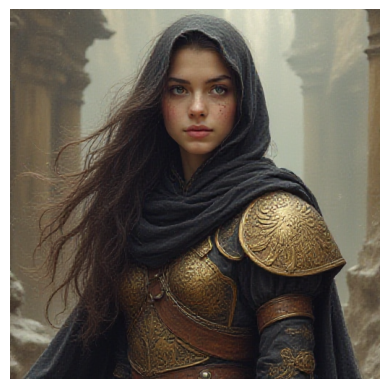


=== Chunk 2 ===
When you are smaller and more fragile than others your life is in danger, because dragons do not bond with weak humans. Violet Sorrengail believed she would join the Scribe Quadrant to live a quiet life, however, on her mother's orders, she must join the thousands of candidates at the Basgiath War College fighting to become part of Navarre's elite: the Dragon Riders Quadrant.
Longitud: 378 caracteres
Tópicos obtenidos: [(18, 0.21755049), (46, 0.09153313), (48, 0.0955582), (49, 0.55534244)]
Etiqueta: world
When you are smaller and more fragile than others your life is in danger, because dragons do not bond with weak humans. Violet Sorrengail believed she would join the Scribe Quadrant to live a quiet life, however, on her mother's orders, she must join the thousands of candidates at the Basgiath War College fighting to become part of Navarre's elite: the Dragon Riders Quadrant.,world


  0%|          | 0/10 [00:00<?, ?it/s]

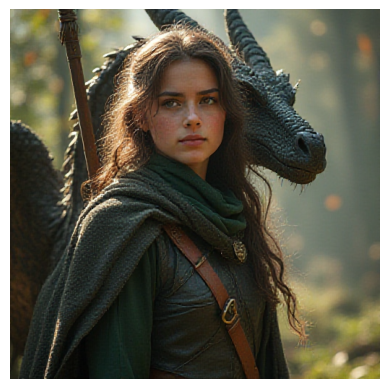


=== Chunk 3 ===
Moreover, with more riders than dragons available, many would kill her in order to improve their chances of success; and there are others, such as the ruthless Xaden Riorson, the most powerful wing leader in the Rider Quadrant, who would kill her simply because she is the daughter of the commanding general.
Longitud: 308 caracteres
Tópicos obtenidos: [(2, 0.054114357), (8, 0.068499126), (15, 0.05366702), (17, 0.22338821), (27, 0.05368164), (48, 0.060820784), (49, 0.44054416)]
Etiqueta: world
Moreover, with more riders than dragons available, many would kill her in order to improve their chances of success; and there are others, such as the ruthless Xaden Riorson, the most powerful wing leader in the Rider Quadrant, who would kill her simply because she is the daughter of the commanding general.,world


  0%|          | 0/10 [00:00<?, ?it/s]

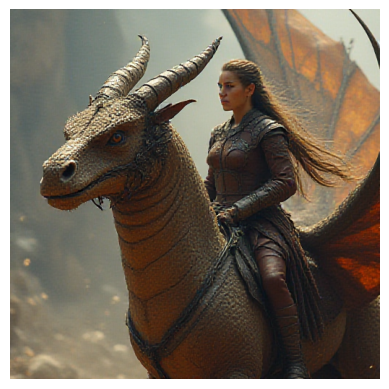


=== Chunk 4 ===
As the war becomes more lethal, Violet suspects that the leaders of Navarre are hiding a terrible secret... When you are smaller and more fragile than others your life is in danger, because dragons do not bond with weak humans.
Longitud: 227 caracteres
Tópicos obtenidos: [(6, 0.1409198), (7, 0.054340564), (28, 0.065998085), (35, 0.08080175), (48, 0.06290586), (49, 0.54001665)]
Etiqueta: world
As the war becomes more lethal, Violet suspects that the leaders of Navarre are hiding a terrible secret... When you are smaller and more fragile than others your life is in danger, because dragons do not bond with weak humans.,world


  0%|          | 0/10 [00:00<?, ?it/s]

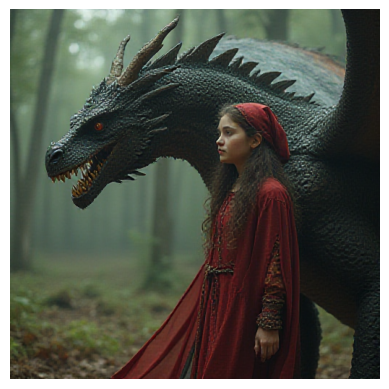

In [10]:
!pip install deepl
import nltk
import deepl

# Cargar la imagen desde la ruta
def mostrarimagen():
  image_path = "/content/ImagenGenerada.png"
  image = mpimg.imread(image_path)
  #Mostrar la imagen
  plt.imshow(image)
  plt.axis('off')  # Ocultar ejes
  plt.show()
  return

# Crear un cliente DeepL con tu clave de API
auth_key = "76f60294-03cb-41d1-9bda-69a352564258:fx"  # Reemplaza con tu clave de API
deepl_client = deepl.DeepLClient(auth_key)

nltk.download('punkt_tab')
chunks = split_text_large_input(input("Ingrese un texto para generar una imagen: "),
                               min_chunk_length=150,
                               split_method="smart",
                               overlap_sentences=1)
#Mostrar los chunks
for i, chunk in enumerate(chunks, 1):
    print(f"\n=== Chunk {i} ===")
    #print(chunk)
    translation = deepl_client.translate_text(chunk, target_lang="EN-US")
    print(translation.text)
    print(f"Longitud: {len(translation.text)} caracteres")
    etiqueta = Generartopico(translation.text)
    translation.text = translation.text + "," + etiqueta
    print(translation.text)
    textoimagen()
    # Cargar la imagen desde la ruta
    mostrarimagen()


# Modelo de LDA Para encontrar topicos en un texto
se ejecuta antes que el codigo de texto a imagen


In [4]:
!pip install pandas
!pip install gensim
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm


import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel


#---------- Esto era para preprocesar el Dataset, pero ya se hizo----------------
# # Cargar el archivo .csv
# data = pd.read_csv('/content/books.csv')

# print(data['description'].isnull().sum())  # Verifica valores nulos
# print(data['description'].unique())        # Verifica valores únicos
# data['description'] = data['description'].fillna("")  # Reemplaza NaN con ""
# print("reemplazando los NaN por ' ' ")
# #print(data['description'].isnull().sum())  # Verifica valores nulos
# #print(data['description'].unique())        # Verifica valores únicos
# print("reemplazando los numero por strings ")
# data['description'] = data['description'].astype(str)  # Convierte todos los valores a strings
#-------------------------------------------------------------------------------

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt

# Descargar y cargar el modelo de spaCy para inglés
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Establecer las palabras vacías
stop_words = STOP_WORDS

# Definir la función de preprocesamiento
def preprocess(text):
    # Procesar el texto con spaCy
    doc = nlp(text.lower())
    # Filtrar tokens
    filtered_tokens = [token.text for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and token.text not in stop_words and token.is_alpha]
    return filtered_tokens

#---------- Esto era para guardar el Dataset preprocesado, pero ya se hizo----------------
# # Aplicar la función de preprocesamiento a las descripciones
# data['processed'] = data['description'].apply(preprocess)

# # # Mostrar el DataFrame resultante
# print(data.head())

# #Guardar los datos en un nuevo archivo para no preprocesarlos a cada rato
# #data.head()
# data.to_csv('DatasetPreprocesado.csv', index=False)
#-------------------------------------------------------------------------------


#-------Esto es para leer el DatasetPreprocesado que se usará para entrenar el modelo LDA----------------
datapreprocesado = pd.read_csv('/content/DatasetPreprocesado.csv')
datapreprocesado = datapreprocesado[["title", "description","processed"]]
datapreprocesado.head(5)

import ast

datapreprocesado['processed'] = datapreprocesado['processed'].apply(ast.literal_eval)
# Crear un diccionario y un corpus
processed_docs = datapreprocesado['processed'].tolist()
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import numpy as np

# Entrenamos el Modelo LDA
lda_model = LdaModel(corpus, num_topics=50, id2word=dictionary, passes=3)

# Obtenemos las distribuciones de palabras para cada tópico
topics = lda_model.get_topics()

# Calcula la similitud del coseno entre tópicos
similarity_matrix = cosine_similarity(topics)

# Aplica K-means clustering
num_clusters = 10  # Número de categorías de libros
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(similarity_matrix)

# Asigna cada tópico a un cluster
clusters = kmeans.labels_

# Muestra los tópicos agrupados
for i in range(num_clusters):
    print(f"Categoría {i + 1}:")
    topics_in_cluster = np.where(clusters == i)[0]
    for topic_idx in topics_in_cluster:
        print(f"Tópico {topic_idx}: {lda_model.print_topic(topic_idx, topn=5)}")
    print("\n")

def Generartopico(test_text):
    # Preprocesamiento del texto
    test_text_tokens = preprocess(test_text)
    test_text_bow = dictionary.doc2bow(test_text_tokens)

    # Obtén la distribución de tópicos para el texto
    test_text_topics = lda_model.get_document_topics(test_text_bow)

    # Verifica los tópicos obtenidos
    print("Tópicos obtenidos:", test_text_topics)

    # Encuentra el tópico con mayor probabilidad
    if test_text_topics:
        top_topic = max(test_text_topics, key=lambda item: item[1])

        # Obtén una palabra del tópico más relevante
        top_word = lda_model.show_topic(top_topic[0], topn=1)[0][0]
        print(f"Etiqueta: {top_word}")
    else:
        print("No se encontraron tópicos relevantes para el texto de prueba.")
    return top_word

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Categoría 1:
Tópico 5: 0.061*"grace" + 0.024*"prayer" + 0.019*"sixth" + 0.018*"ad" + 0.017*"praise"
Tópico 23: 0.020*"cult" + 0.012*"base" + 0.011*"medium" + 0.011*"teams" + 0.010*"invasion"
Tópico 27: 0.026*"insightful" + 0.021*"respected" + 0.017*"champion" + 0.016*"bird" + 0.015*"lion"
Tópico 29: 0.164*"die" + 0.052*"und" + 0.036*"sin" + 0.033*"roman" + 0.026*"met"
Tópico 36: 0.028*"excitement" + 0.026*"m" + 0.019*"report" + 0.016*"racism" + 0.013*"surprisingly"
Tópico 43: 0.074*"cat" + 0.037*"journal" + 0.027*"marks" + 0.026*"tips" + 0.023*"format"


Categoría 2:
Tópico 6:

In [5]:
!pip install pyLDAvis

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.0 MB/s eta 0:00:00
